# DEPENDENCIES

In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import glob
import multiprocessing
import tqdm
import sys
from cdo import Cdo
cdo = Cdo()

## get my stats functions
from mystatsfunctions import OLSE,LMoments
from moarpalettes import get_palette

## get fair
from fair import *

## plotting functions for notebooks
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn as sn
sn.set_context("paper",font_scale=1.2)

## matplotlib rcParams
## IF you want to use thesis style

import requests
from io import StringIO, BytesIO

req = requests.get('https://raw.githubusercontent.com/njleach/Thesis/main/ancil/figure-style.mplstyle')

with open("/home/l/leach/thesis.mplstyle", "w") as text_file:
    text_file.write(req.content.decode())
    
plt.style.use("/home/l/leach/thesis.mplstyle")
textwidth = matplotlib.rcParams['figure.figsize'][0]

%matplotlib inline

/home/l/leach/installed-packages/miniconda3/lib/python3.7/site-packages/xarray/backends/cfgrib_.py:28: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  "Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. "


# SET ARGUMENTS

In [2]:
outdir = "/network/group/aopp/predict/AWH012_LEACH_NASTORM/IC-PREP/output/"
inidate="20220214"
restartdir = "/network/group/aopp/predict/AWH012_LEACH_NASTORM/IC-PREP/restarts/"+inidate+"/"

# RETRIEVE DATA

In [3]:
## ORCA025Z75 mask
ORCA025Z75_lsm = xr.open_dataset('/network/group/aopp/predict/AWH012_LEACH_NASTORM/IC-PREP/source/si/mesh_mask.nc')

## Tco639 land-sea mask
# Tco639_lsm = xr.open_dataset('../Ancil/Tco_639.grib')

/home/l/leach/installed-packages/miniconda3/lib/python3.7/site-packages/xarray/backends/plugins.py:68: RuntimeWarning: Engine 'cfgrib' loading failed:
libffi.so.7: cannot open shared object file: No such file or directory
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


# CHECK OCEAN RESTARTS

In [4]:
restart_list = glob.glob(restartdir+'*/*restart.nc')

Import data & carry out check 1: no "rhop" in perturbed restarts

In [5]:
def get_restart_and_perturbed(fpath):
    opa = fpath.split('/')[-2]
    fname = fpath.split('/')[-1]
    expver = fname.split('_')[0]
    
    restart = xr.open_dataset(fpath,chunks={'z':1}).expand_dims({'rtype':['original']})
    pi = xr.open_dataset(outdir+'pi-co2/'+expver+'/'+opa+'/'+'restart/2022/'+fname,chunks={'z':1}).expand_dims({'rtype':['pi-co2']})
    incr = xr.open_dataset(outdir+'incr-co2/'+expver+'/'+opa+'/'+'restart/2022/'+fname,chunks={'z':1}).expand_dims({'rtype':['incr-co2']})
    
    ## check 1: rhop deleted:
    print(opa+' variables in original NOT in perturbed:')
    print('pi-co2',set(restart.keys()) ^ pi.keys())
    print('incr-co2',set(restart.keys()) ^ incr.keys(),'\n')
    
    symdiff_vars = list(set(restart.keys()) ^ pi.keys())
    
    return xr.concat([restart.drop(symdiff_vars),pi,incr],dim='rtype').expand_dims({'opa':[opa]})

In [6]:
all_restarts = xr.concat([get_restart_and_perturbed(x) for x in restart_list],dim='opa')

opa0 variables in original NOT in perturbed:
pi-co2 {'rhop'}
incr-co2 {'rhop'} 

opa1 variables in original NOT in perturbed:
pi-co2 {'rhop'}
incr-co2 {'rhop'} 

opa2 variables in original NOT in perturbed:
pi-co2 {'rhop'}
incr-co2 {'rhop'} 

opa3 variables in original NOT in perturbed:
pi-co2 {'rhop'}
incr-co2 {'rhop'} 

opa4 variables in original NOT in perturbed:
pi-co2 {'rhop'}
incr-co2 {'rhop'} 



carry out check 2: pi == -1 * incr (check max differences are small)

In [7]:
tn_diff_from_original = (all_restarts.sel(rtype='original').tn - all_restarts.tn)

In [8]:
pi_incr_maxdiff = (tn_diff_from_original.sel(rtype='pi-co2') + tn_diff_from_original.sel(rtype='incr-co2')).max(['x','y','t']).to_dataframe()

Text(0.5, 1.0, 'heatmap of perturbation differences')

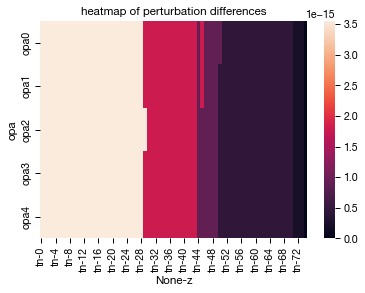

In [9]:
sn.heatmap(pi_incr_maxdiff.unstack())
plt.title('heatmap of perturbation differences')

carry out check 3: ALL perturbations equal

In [10]:
opa_maxdiff = tn_diff_from_original.sel(rtype='pi-co2').diff('opa').max(['x','y','t']).to_dataframe()

Text(0.5, 1.0, 'heatmap of opa differences')

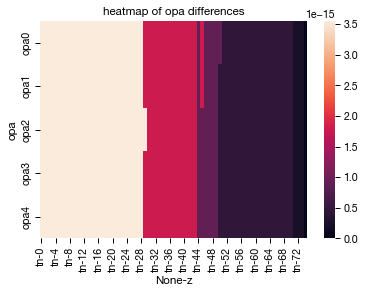

In [11]:
sn.heatmap(pi_incr_maxdiff.unstack())
plt.title('heatmap of opa differences')

carry out check 4: salinity not same as original

In [12]:
sn_diff_from_original = (all_restarts.sel(rtype='original').sn - all_restarts.sn)

In [13]:
sn_meandiff = sn_diff_from_original.where(ORCA025Z75_lsm.tmask).mean(['x','y','t']).to_dataframe()

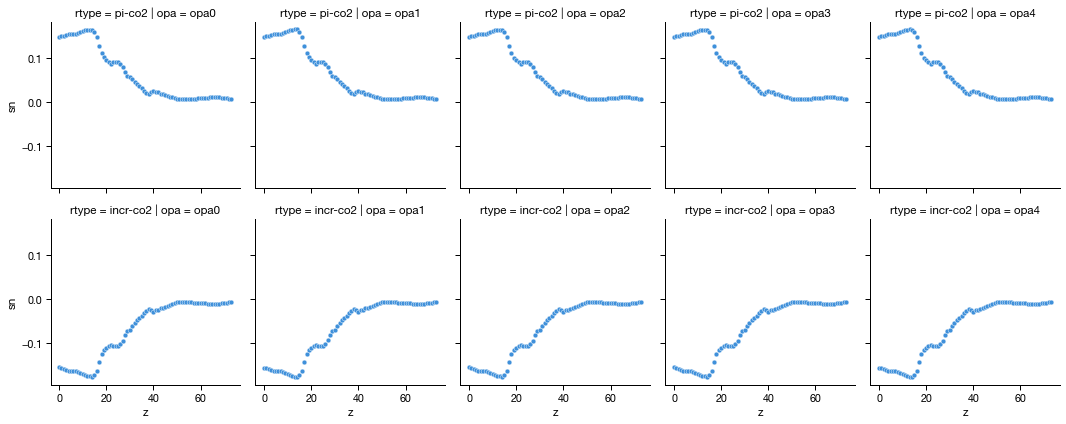

In [14]:
g=sn.FacetGrid(sn_meandiff.reset_index().query('rtype!="original"'),col='opa',row='rtype')
g.map(sn.scatterplot, 'z' ,'sn')

checks complete, everything looks good so plot the perturbation one last time

''

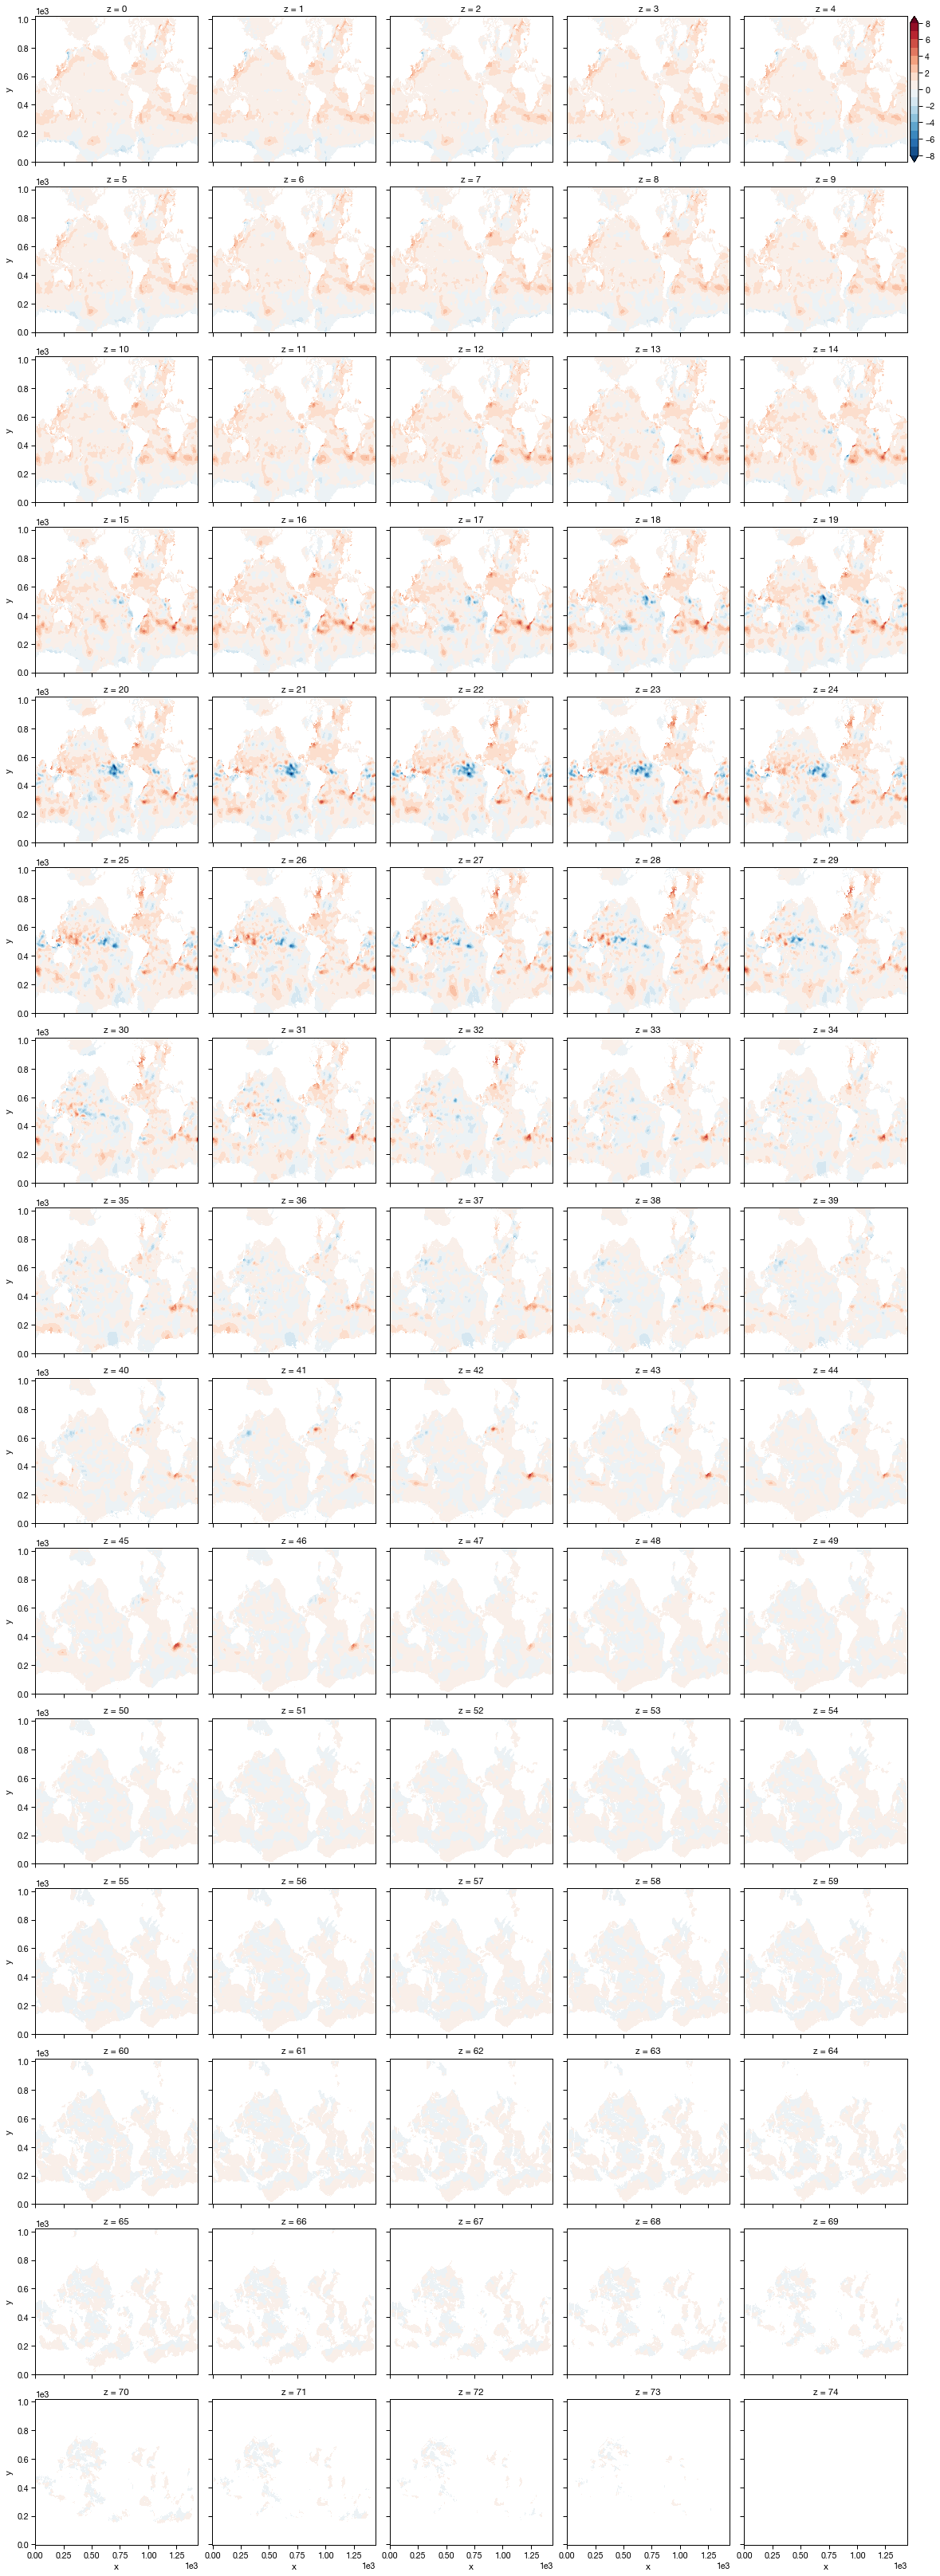

In [15]:
p=tn_diff_from_original.sel(opa='opa0',rtype='pi-co2').where(ORCA025Z75_lsm.tmask).squeeze().plot(levels=np.linspace(-8,8,17),extend='both',col='z',col_wrap=5,cmap='RdBu_r',add_colorbar=False)

axins = inset_axes(p.axes[0,-1], width="5%",height="100%",loc='lower left',bbox_to_anchor=(1.02, 0.00, 1, 1),bbox_transform=p.axes[0,-1].transAxes,borderpad=0)
cbar=plt.colorbar(p.axes[0,-1].collections[0],cax=axins)
''

All looks as expected!

## CHECK ICE RESTARTS

In [16]:
restart_list = glob.glob(restartdir+'*/*restart_ice.nc')

Import data & carry out (redundant) check #1

In [17]:
all_restarts_ice = xr.concat([get_restart_and_perturbed(x) for x in restart_list],dim='opa')

opa0 variables in original NOT in perturbed:
pi-co2 set()
incr-co2 set() 

opa1 variables in original NOT in perturbed:
pi-co2 set()
incr-co2 set() 

opa2 variables in original NOT in perturbed:
pi-co2 set()
incr-co2 set() 

opa3 variables in original NOT in perturbed:
pi-co2 set()
incr-co2 set() 

opa4 variables in original NOT in perturbed:
pi-co2 set()
incr-co2 set() 



carry out check 1: lead fraction -> (0 - 1)

In [18]:
print('max frlead value:')
all_restarts_ice.frld.max(['x','y','t']).to_dataframe().unstack()
# should be one

max frlead value:


frld                
rtype original pi-co2 incr-co2
opa                           
opa0       1.0    1.0      1.0
opa1       1.0    1.0      1.0
opa2       1.0    1.0      1.0
opa3       1.0    1.0      1.0
opa4       1.0    1.0      1.0

In [19]:
print('min frlead value:')
all_restarts_ice.frld.min(['x','y','t']).to_dataframe().unstack()
# should be zero

min frlead value:


frld                
rtype original pi-co2 incr-co2
opa                           
opa0       0.0    0.0      0.0
opa1       0.0    0.0      0.0
opa2       0.0    0.0      0.0
opa3       0.0    0.0      0.0
opa4       0.0    0.0      0.0

carry out check 2: hicif >= 0

In [20]:
print('min hicif value:')
all_restarts_ice.hicif.min(['x','y','t']).to_dataframe().unstack()
# should be zero

min hicif value:


hicif                
rtype original pi-co2 incr-co2
opa                           
opa0       0.0    0.0      0.0
opa1       0.0    0.0      0.0
opa2       0.0    0.0      0.0
opa3       0.0    0.0      0.0
opa4       0.0    0.0      0.0

carry out check 3: if frld == 1, hicif == 0

In [21]:
print('sum of hicif where frld == 1')
(all_restarts_ice.hicif.where(all_restarts_ice.frld==1)**2).sum(['x','y','t']).to_dataframe().unstack()
# should be zero

sum of hicif where frld == 1


hicif                
rtype original pi-co2 incr-co2
opa                           
opa0       0.0    0.0      0.0
opa1       0.0    0.0      0.0
opa2       0.0    0.0      0.0
opa3       0.0    0.0      0.0
opa4       0.0    0.0      0.0

carry out check 3: if hicif == 0, frld == 1

In [22]:
print('mean of frld where hicif == 0')
all_restarts_ice.frld.where(all_restarts_ice.hicif==0).mean(['x','y','t']).to_dataframe().unstack()
# should be one exactly

mean of frld where hicif == 0


frld                
rtype  original pi-co2 incr-co2
opa                            
opa0   0.998933    1.0      1.0
opa1   0.998933    1.0      1.0
opa2   0.998931    1.0      1.0
opa3   0.998933    1.0      1.0
opa4   0.998931    1.0      1.0

initial checks complete, all looks good so plot fields

''

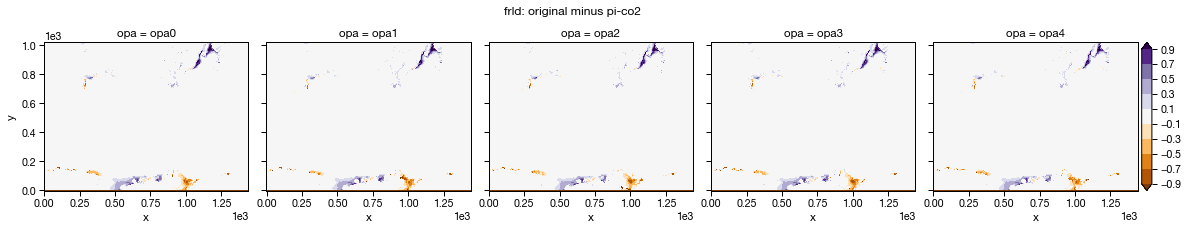

In [23]:
p=(all_restarts_ice.frld.sel(rtype='original')-all_restarts_ice.frld.sel(rtype='pi-co2')).squeeze().plot(levels=np.linspace(-0.9,0.9,10),extend='both',col='opa',cmap='PuOr',add_colorbar=False)

axins = inset_axes(p.axes[0,-1], width="5%",height="100%",loc='lower left',bbox_to_anchor=(1.02, 0.00, 1, 1),bbox_transform=p.axes[0,-1].transAxes,borderpad=0)
cbar=plt.colorbar(p.axes[0,-1].collections[0],cax=axins)
p.fig.suptitle('frld: original minus pi-co2',y=1.05)
''

In [24]:
## set up nice colormap for plotting ice
from copy import copy

frldcmap = copy(matplotlib.cm.Blues)
frldcmap.set_bad(color='grey')

''

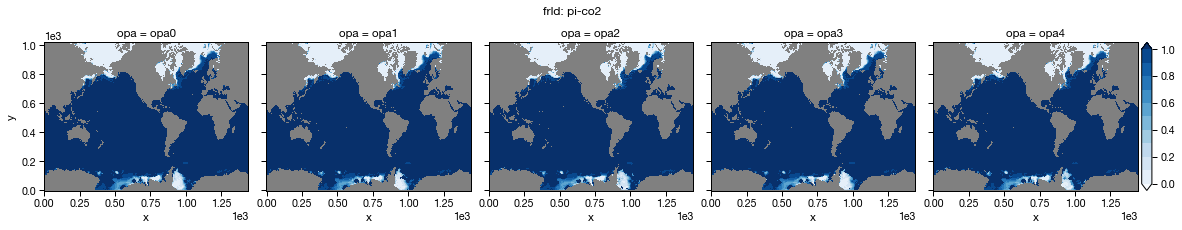

In [25]:
p=all_restarts_ice.frld.sel(rtype='pi-co2').where(ORCA025Z75_lsm.tmask.isel(z=0)).squeeze().plot(levels=np.linspace(0,1,11),extend='both',col='opa',cmap=frldcmap,add_colorbar=False)

axins = inset_axes(p.axes[0,-1], width="5%",height="100%",loc='lower left',bbox_to_anchor=(1.02, 0.00, 1, 1),bbox_transform=p.axes[0,-1].transAxes,borderpad=0)
cbar=plt.colorbar(p.axes[0,-1].collections[0],cax=axins)
p.fig.suptitle('frld: pi-co2',y=1.05)
''

''

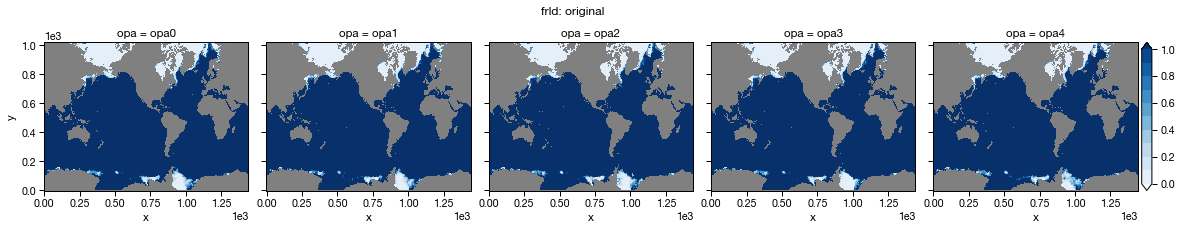

In [26]:
p=all_restarts_ice.frld.sel(rtype='original').where(ORCA025Z75_lsm.tmask.isel(z=0)).squeeze().plot(levels=np.linspace(0,1,11),extend='both',col='opa',cmap=frldcmap,add_colorbar=False)

axins = inset_axes(p.axes[0,-1], width="5%",height="100%",loc='lower left',bbox_to_anchor=(1.02, 0.00, 1, 1),bbox_transform=p.axes[0,-1].transAxes,borderpad=0)
cbar=plt.colorbar(p.axes[0,-1].collections[0],cax=axins)
p.fig.suptitle('frld: original',y=1.05)
''

''

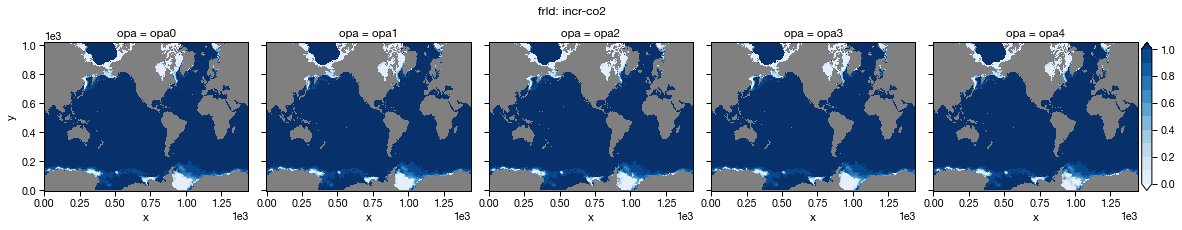

In [27]:
p=all_restarts_ice.frld.sel(rtype='incr-co2').where(ORCA025Z75_lsm.tmask.isel(z=0)).squeeze().plot(levels=np.linspace(0,1,11),extend='both',col='opa',cmap=frldcmap,add_colorbar=False)

axins = inset_axes(p.axes[0,-1], width="5%",height="100%",loc='lower left',bbox_to_anchor=(1.02, 0.00, 1, 1),bbox_transform=p.axes[0,-1].transAxes,borderpad=0)
cbar=plt.colorbar(p.axes[0,-1].collections[0],cax=axins)
p.fig.suptitle('frld: incr-co2',y=1.05)
''

In [ ]:
p=(all_restarts_ice.hicif.sel(rtype='original')-all_restarts_ice.hicif.sel(rtype='pi-co2')).squeeze().plot(levels=np.linspace(-4.5,4.5,10),extend='both',col='opa',cmap='BrBG',add_colorbar=False)

axins = inset_axes(p.axes[0,-1], width="5%",height="100%",loc='lower left',bbox_to_anchor=(1.02, 0.00, 1, 1),bbox_transform=p.axes[0,-1].transAxes,borderpad=0)
cbar=plt.colorbar(p.axes[0,-1].collections[0],cax=axins)
p.fig.suptitle('hicif: original minus pi-co2',y=1.05)
''

''

All looks as expected!

# CHECK SST DELTAS

In [ ]:
pi_sstdelta = xr.open_dataset(outdir+'pi-co2/sstdelta/sstdelta.grib')
incr_sstdelta = xr.open_dataset(outdir+'incr-co2/sstdelta/sstdelta.grib')

carry out check 1: pi == -1 * incr (check max differences are small)

In [ ]:
print('max value of pi-co2 + incr-co2 sstdeltas')
(pi_sstdelta + incr_sstdelta).dte.max().values[()]

Check completed so plot.

In [ ]:
plt.scatter(pi_sstdelta.longitude,pi_sstdelta.latitude,c=pi_sstdelta.dte,cmap='RdBu_r',vmin=-2,vmax=2)

In [ ]:
plt.scatter(incr_sstdelta.longitude,incr_sstdelta.latitude,c=incr_sstdelta.dte,cmap='RdBu_r',vmin=-2,vmax=2)

All looks as expected!